In [ ]:
# !pip install langchain langgraph langchain-google-genai langchain-core langchain-community langchain-experimental fpdf pdfplumber

In [491]:
from langchain_core.runnables import RunnableConfig
from langchain.schema import AIMessage
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import PromptTemplate
from langchain_core.tools import tool
from langchain_community.agent_toolkits import FileManagementToolkit
from langchain_experimental.tools.python.tool import PythonAstREPLTool
from pydantic import BaseModel, Field
from fpdf import FPDF
import random
import pdfplumber
import os
import requests
import warnings
import dotenv

warnings.filterwarnings("ignore")
dotenv.load_dotenv()

True

In [493]:
os.environ["google_api_key"] = google_api_key
os.environ["GOOGLE_API_KEY"] = google_api_key
os.environ["TAVILY_API_KEY"] = tavily_api_key

In [494]:
class State(TypedDict):
    query : Annotated[str, "User Question"]
    answer : Annotated[str, "LLM response"]
    messages : Annotated[list, add_messages]
    tool_call : Annotated[dict, "Tool Call Result"]

In [495]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash",
                             temperature=0)

In [496]:
@tool
def read_pdf(file_path: str) -> str:
    """
    PDF 파일에서 텍스트를 추출하는 도구입니다.
    표 형식 또는 일반 텍스트가 포함된 PDF를 읽고 문자열로 반환합니다.

    file_path 예시: './report.pdf'
    """
    try:
        text = ""
        with pdfplumber.open(file_path) as pdf:
            for page in pdf.pages:
                page_text = page.extract_text()
                if page_text:
                    text += page_text + "\n"
        return text.strip() if text.strip() else "❌ PDF에서 텍스트를 추출할 수 없습니다."
    except Exception as e:
        return f"❌ PDF 읽기 오류: {str(e)}"

In [ ]:
@tool
def write_pdf(content: str, filename: str = "output.pdf"):
    """
    텍스트를 PDF 파일로 저장하는 도구입니다.
    PDF형태의 문서로 만들어야할 때 이 도구를 사용하세요.
    """

    prompt = PromptTemplate.from_template("""
            당신은 보고서를 작성하는 어시스턴트입니다. 당신에겐 문서 모음이 제공되고 이를 잘 분석하여 보고서를 작성하여야 합니다.
            아래의 content는 문서 모음입니다. 문서의 제목, 본문을 잘 판단하고 정리하여 요약합니다.
            항상 구조화된 출력을 제공하세요.                           
            항상 마지막엔 인사이트도 첨부합니다.               
            
            content : {content}
            """)
    
    chain = prompt | llm

    content = chain.invoke({"content":content}).content

    font_url = "https://github.com/google/fonts/raw/main/ofl/notosanskr/NotoSansKR%5Bwght%5D.ttf"
    font_path = "./fonts/NotoSansKR.ttf"

    try:
        os.mkdir("./fonts/")
        response = requests.get(font_url)
        with open(font_path, "wb") as f:
            f.write(response.content)
    except:
        pass

    pdf = FPDF()
    pdf.add_page()
    pdf.set_auto_page_break(auto=True, margin=15)

    font_path = "./fonts/NotoSansKR.ttf"  # <-- 여기에 실제 폰트 파일이 있어야 함

    try:
        pdf.add_font("NotoSans", "", font_path, uni=True)
        pdf.set_font("NotoSans", size=12)
    except:
        raise ValueError("한글 폰트를 등록할 수 없습니다.")

    for line in content.split("\n"):
        pdf.multi_cell(0, 10, line)
    pdf.output(f"./{filename}")

    return f"{filename} 저장 완료"

In [498]:
tools = [TavilySearchResults(), PythonAstREPLTool(), write_pdf, read_pdf, *FileManagementToolkit(
                                                                            selected_tools=["file_delete","list_directory"]).get_tools()]
search_tool, code_tool, write_tool, read_tool, delete_tool, listdir_tool= tools

In [499]:
# tools = [TavilySearchResults(include_domains=["naver.com", "google.com"]), PythonAstREPLTool(), write_pdf, read_pdf, *FileManagementToolkit(
#                                                                             selected_tools=["file_delete","list_directory"]).get_tools()]
# search_tool, code_tool, write_tool, read_tool, delete_tool, listdir_tool= tools

In [500]:
# write_tool({"content":"안녕하세요?", "filename":"abctest.pdf"})

In [501]:
# read_tool("abctest.pdf")

In [502]:
# delete_tool("abctest.pdf")

In [503]:
llm_with_tools = llm.bind_tools(tools)

In [504]:
class HistoryChecker(BaseModel):
    """
    이전의 대화 기록을 참고하여 질문에 대해 답변할 수 있는지 판단합니다.
    답변할 수 있다면 "yes", 답변할 수 없다면 "no"를 반환합니다.
    """

    yes_no : Literal["yes", "no"] = Field(..., description="""Use your previous conversation history to determine if you can answer your questions.
    Return "yes" if you can answer, "no" if you can't answer.""")

In [505]:
def shorterm_memory(state:State):

    if len(state["messages"]) > 8:
        history = state["messages"][-8:-1]
    elif len(state["messages"]) == 1:
        history = ""
    else:
        history = state["messages"][:-1]

    return history

In [506]:
def history_check(state:State):

    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변할 수 있는지 판단합니다.
                답변할 수 있다면 "yes", 답변할 수 없다면 "no"를 반환합니다.

                대화 기록 : {history}

                질문 : {query}

                """)

    chain = prompt | history_checker

    history = shorterm_memory(state)

    result = chain.invoke({"history":history,
                            "query":state["query"]})

    return result.yes_no

In [507]:
def memory_chat(state:State):

    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변하세요.
                아래 대화 기록을 첨부합니다.
                대화 기록을 통해 답변이 어렵다면 내부 지식을 참조하세요.

                대화 기록 : {history}

                질문 : {query}

                """)


    chain = prompt | llm

    history = shorterm_memory(state)

    answer = chain.invoke({"history":history,
                           "query":state["query"]})

    if len(state["tool_call"]) == 0:
        return {"answer":answer.content,
                "messages":[answer],
                "tool_call":"사용된 기록 없음."}
    else:
        return {"answer":answer.content,
                "messages":[answer]}

In [508]:
history_checker = llm.with_structured_output(HistoryChecker)

In [509]:
def history_node(state:State):
    if len(state["messages"]) == 1:
        return {"answer":"답변 없음",
                "tool_call":"사용된 도구 없음"}
    else:
        return state

In [510]:
def select(
    state: State,
):

    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변하세요.
                아래 대화 기록을 첨부합니다.
                이전의 대화가 다음에 어떤 도구를 사용해야하는지 힌트가 될 수 있습니다. 꼭 참조하세요.
                도구의 변화가 큰 결과를 가져올 수 있습니다.
                들어온 메시지, 정답, 이전 기록을 모두 분석하여 가장 적절한 도구를 선택하세요.

                대화 기록 : {history}

                최근 사용한 도구 : {tool_name}

                정답 : {answer}

                질문 : {query}

                """)

    chain = prompt | llm_with_tools

    history = shorterm_memory(state)

    result = chain.invoke({"history" : history,
                           "tool_name" : state["tool_call"],
                            "answer": state["answer"],
                            "query": state["query"]})

    if hasattr(result, "tool_calls") and len(result.tool_calls) > 0:
        tool_calls = result.tool_calls
        return {"messages": result,
                "tool_call": [result]}
    else:
        return {"messages":AIMessage(content=f"""도구를 선택하지 못했습니다. 적절한 도구를 재선택하세요.
                                        """),
                                    "tool_call":None}



In [511]:
tool_node = ToolNode(tools)

In [512]:
class AnswerChecker(BaseModel):
    """
    정답 분류기입니다.

    정답이 질문을 해결했는지 여부를 판단합니다.
    질문을 해결하지 못했을 시 해결될 때까지 도구를 이용합니다.

    질문을 해결했다면 "end", 해결하지 못했다면 "tool"을 반환합니다.
    """


    end : Literal["end", "tool"] = Field(..., description="""You are the answer sorter.

                                                                Determine if the correct answer has solved the question.
                                                                If the question is not resolved, use the tool until it is resolved.

                                                                Return "end" if you solved the question, or "tool" if you didn't.""")

In [513]:
answer_checker = llm.with_structured_output(AnswerChecker)

In [514]:
def response(state:State):

    return {"answer":state["messages"][-1]}

In [515]:
def answer_check(state:State):

    prompt = PromptTemplate.from_template("""
    당신은 정답 분류기 어시스턴트입니다.

    정답이 질문을 해결하였는지 여부를 판단합니다.
    질문을 해결하지 못했다면 도구를 이용합니다.

    질문을 해결하였다면 "end", 아니라면 "tool"을 반환합니다.

    기존 History도 참고하여 답변하세요.

    History : {history}

    정답 : {answer}

    질문 : {query}
    """)

    chain = prompt | answer_checker

    history = shorterm_memory(state)

    result = chain.invoke({"history" : history,
                            "answer": state["answer"],
                            "query": state["query"]})

    return result.end

In [516]:
graph_builder = StateGraph(State)

In [517]:
graph_builder.add_node("history_node", history_node)
graph_builder.add_node("memory_chat", memory_chat)
graph_builder.add_node("select", select)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("response", response)


graph_builder.add_edge(START, "history_node")
graph_builder.add_conditional_edges("history_node",
                            history_check,
                            {"yes":"memory_chat",
                             "no":"select"})
graph_builder.add_edge("select", "tools")
graph_builder.add_edge("tools", "response")
graph_builder.add_edge("memory_chat", "response")
graph_builder.add_conditional_edges("response",
                                    answer_check,
                                    {"end":END,
                                    "tool":"select"});

In [518]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

In [519]:
def reset_config(limit=20):

    thread_id=random.randint(1,999999)

    config = RunnableConfig(recursion_limit=limit, configurable={"thread_id": thread_id})

    return config

In [520]:
config = reset_config()

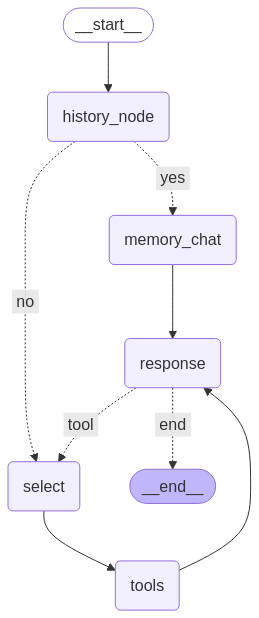

In [521]:
graph

In [522]:
def streaming(query, config):

    result = graph.stream({"messages":("user", query),
                         "query":query}, config=config)
    for step in result:
        for k, v in step.items():
            print(f"\n\n=== {k} ===\n\n")
            print(v)

    return

In [523]:
query = "1+1은 뭔가요?"

streaming(query, config)



=== history_node ===


{'answer': '답변 없음', 'tool_call': '사용된 도구 없음'}


=== memory_chat ===


{'answer': '2', 'messages': [AIMessage(content='2', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-babda064-d8a1-4e82-8463-4228851dca27-0', usage_metadata={'input_tokens': 86, 'output_tokens': 2, 'total_tokens': 88, 'input_token_details': {'cache_read': 0}})]}


=== response ===


{'answer': AIMessage(content='2', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-babda064-d8a1-4e82-8463-4228851dca27-0', usage_metadata={'input_tokens': 86, 'output_tokens': 2, 'total_tokens': 88, 'input_token_details': {'cache_read': 0}})}


In [526]:
config = reset_config()

query = "테슬라에 대해 조사해서 레포트로 만들어주세요. 파일 형식은 pdf로 저장해주세요."

streaming(query, config)



=== history_node ===


{'answer': '답변 없음', 'tool_call': '사용된 도구 없음'}


=== select ===


{'messages': AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "\\ud14c\\uc2ac\\ub77c"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-b83b6129-8b3e-4081-9fad-780e3b530633-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '테슬라'}, 'id': '61447bbd-450e-448a-96a9-ba0eb14c4556', 'type': 'tool_call'}], usage_metadata={'input_tokens': 417, 'output_tokens': 12, 'total_tokens': 429, 'input_token_details': {'cache_read': 0}}), 'tool_call': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "\\ud14c\\uc2ac\\ub77c"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STO

In [527]:
config = reset_config()

query = "피엔티라는 회사에 대해 조사해주세요. 잘 정리된 보고서를 제공해주십시오. pdf파일로 받기를 희망합니다."

streaming(query, config)



=== history_node ===


{'answer': '답변 없음', 'tool_call': '사용된 도구 없음'}


=== select ===


{'messages': AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "\\ud53c\\uc5d4\\ud2f0 \\ud68c\\uc0ac"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-c19a4e02-9650-4fa5-b907-4d27e11b6daa-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '피엔티 회사'}, 'id': '99556e74-f855-403b-868c-99c362cd2ad2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 425, 'output_tokens': 14, 'total_tokens': 439, 'input_token_details': {'cache_read': 0}}), 'tool_call': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "\\ud53c\\uc5d4\\ud2f0 \\ud68c\\uc0ac"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_rat

In [528]:
config = reset_config()

query = "피엔티의 경쟁사에 대한 정보도 정리된 보고서를 작성해주세요."

streaming(query, config)



=== history_node ===


{'answer': '답변 없음', 'tool_call': '사용된 도구 없음'}


=== select ===


{'messages': AIMessage(content='피엔티의 경쟁사에 대한 정보가 필요하므로, 먼저 검색을 통해 관련 정보를 수집해야 합니다. 그 후, 수집된 정보를 바탕으로 보고서를 작성하는 것이 적절합니다. 따라서 먼저 `tavily_search_results_json` 도구를 사용하여 피엔티 경쟁사에 대한 정보를 검색하겠습니다.', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "\\ud53c\\uc5d4\\ud2f0 \\uacbd\\uc7c1\\uc0ac"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-55d86f7d-cc1d-49e0-87aa-f97b36bef9d7-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '피엔티 경쟁사'}, 'id': '1076d441-0f89-4f5d-96cc-ce389f021276', 'type': 'tool_call'}], usage_metadata={'input_tokens': 411, 'output_tokens': 101, 'total_tokens': 512, 'input_token_details': {'cache_read': 0}}), 'tool_call': [AIMessage(content='피엔티의 경쟁사에 대한 정보가 필요하므로, 먼저 검색을 통해 관련 정보를 수집해야 합니

In [529]:
query = "피엔티의 경쟁사의 매출도 조사해서 보고서로 정리해줘"

streaming(query, config)



=== history_node ===


{'query': '피엔티의 경쟁사의 매출도 조사해서 보고서로 정리해줘', 'answer': ToolMessage(content='피엔티 경쟁사 정보 보고서.pdf 저장 완료', name='write_pdf', id='19f0cc75-5ca7-4302-ae7c-4cd5a0707c02', tool_call_id='7375cea0-1011-46cc-9ed8-d9391b121511'), 'messages': [HumanMessage(content='피엔티의 경쟁사에 대한 정보도 정리된 보고서를 작성해주세요.', additional_kwargs={}, response_metadata={}, id='cfc6dc98-f551-43ca-a93e-37377aa2492d'), AIMessage(content='피엔티의 경쟁사에 대한 정보가 필요하므로, 먼저 검색을 통해 관련 정보를 수집해야 합니다. 그 후, 수집된 정보를 바탕으로 보고서를 작성하는 것이 적절합니다. 따라서 먼저 `tavily_search_results_json` 도구를 사용하여 피엔티 경쟁사에 대한 정보를 검색하겠습니다.', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "\\ud53c\\uc5d4\\ud2f0 \\uacbd\\uc7c1\\uc0ac"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-55d86f7d-cc1d-49e0-87aa-f97b36bef9d7-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': 

In [531]:
config = reset_config()

query = "현재 폴더의 pdf로 이루어진 파일 모두 삭제해줘"

streaming(query, config)



=== history_node ===


{'answer': '답변 없음', 'tool_call': '사용된 도구 없음'}


=== select ===


{'messages': AIMessage(content='', additional_kwargs={'function_call': {'name': 'list_directory', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-8f5c4b45-1fb2-44b3-9dc1-208cfe9afd19-0', tool_calls=[{'name': 'list_directory', 'args': {}, 'id': '9447cd28-f688-4ef9-87a2-d13a8b631e69', 'type': 'tool_call'}], usage_metadata={'input_tokens': 405, 'output_tokens': 3, 'total_tokens': 408, 'input_token_details': {'cache_read': 0}}), 'tool_call': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'list_directory', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-8f5c4b45-1fb2-44b3-9dc1-208cfe9afd19-0', tool_

In [179]:
config = reset_config()

code = """
아래 코드 실행시켜주세요.

```python

result = 0

for i in range(20):
    print(f"{i+1}번째 출력: ", i)
    result += i

print("최종 결과: ", result)

```
"""

streaming(code, config)



=== history_node ===


{'answer': '답변 없음', 'tool_call': '사용된 도구 없음'}


=== select ===


{'messages': AIMessage(content='', additional_kwargs={'function_call': {'name': 'python_repl_ast', 'arguments': '{"query": "\\nresult = 0\\n\\nfor i in range(20):\\n    print(f\\"{i+1}\\ubc88\\uc9f8 \\ucd9c\\ub825: \\", i)\\n    result += i\\n\\nprint(\\"\\ucd5c\\uc885 \\uacb0\\uacfc: \\", result)\\n"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-d924f11e-47f6-43e9-83f8-081253dbb043-0', tool_calls=[{'name': 'python_repl_ast', 'args': {'query': '\nresult = 0\n\nfor i in range(20):\n    print(f"{i+1}번째 출력: ", i)\n    result += i\n\nprint("최종 결과: ", result)\n'}, 'id': '8d75286a-0ae1-4011-a2f7-434e0a432068', 'type': 'tool_call'}], usage_metadata={'input_tokens': 431, 'output_tokens': 53, 'total_tokens': 484, 'input_token_details': {'cache_read': 0}}), 'tool_call': [AIMessag

In [180]:
config = reset_config()

streaming("""모두의연구소는 어떤 곳이야?
          깔끔하게 정리해서 레포트로 만들어줘.
          레포트의 형식은 pdf로 저장해주면 돼.
          이름은 "모두의연구소_레포트.pdf"로 해줘.""", config)



=== history_node ===


{'answer': '답변 없음', 'tool_call': '사용된 도구 없음'}


=== memory_chat ===


{'answer': '죄송합니다. 이전 대화 기록에 모두의연구소에 대한 정보가 없어 레포트를 작성할 수 없습니다. \n\n모두의연구소에 대한 정보를 알려주시면 깔끔하게 정리하여 PDF 레포트를 만들어 드리겠습니다.', 'messages': [AIMessage(content='죄송합니다. 이전 대화 기록에 모두의연구소에 대한 정보가 없어 레포트를 작성할 수 없습니다. \n\n모두의연구소에 대한 정보를 알려주시면 깔끔하게 정리하여 PDF 레포트를 만들어 드리겠습니다.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-74d5bdf8-1db1-4031-9743-f8cc6d63fca2-0', usage_metadata={'input_tokens': 145, 'output_tokens': 68, 'total_tokens': 213, 'input_token_details': {'cache_read': 0}})]}


=== response ===


{'answer': AIMessage(content='죄송합니다. 이전 대화 기록에 모두의연구소에 대한 정보가 없어 레포트를 작성할 수 없습니다. \n\n모두의연구소에 대한 정보를 알려주시면 깔끔하게 정리하여 PDF 레포트를 만들어 드리겠습니다.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'S